# Fragility-based disruption
The available disruption scenarios in the package do not consider the specific characteristics of the hazards and the fragility of the infrastructure components. For more accurate analysis, an external hazard- and fragility analysis model can be used to generate direct disruptions in the networks and then use it as input for network level simulations using InfraRisk. This notebook shows how to generate disruptions if the hazard fields (for e.g., in the case of earthquakes, PGA or PGV) and the fragility curves are provided.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

from pathlib import Path
from infrarisk.src.physical.integrated_network import IntegratedNetwork
from infrarisk.src.hazards.fragility_based import FragilityBasedDisruption

import pandas as pd
import geopandas as gpd

import warnings
warnings.filterwarnings('ignore')

### Load the micropolis network

In [2]:
shelby_network = IntegratedNetwork(name = 'Shelby County')

In [3]:
MAIN_DIR = Path('../..')
network_dir= 'infrarisk/data/networks/shelby'
water_folder = MAIN_DIR/f'{network_dir}/water'
power_folder = MAIN_DIR/f'{network_dir}/power'
transp_folder = MAIN_DIR/f'{network_dir}/transportation/reduced'

# load all infrastructure networks
shelby_network.load_networks(water_folder, 
                                 power_folder, 
                                 transp_folder, 
                                 power_sim_type = '1ph', 
                                 water_sim_type = "PDA")
shelby_network.generate_integrated_graph(basemap = True)

Water network successfully loaded from ..\..\infrarisk\data\networks\shelby\water/water.inp. The analysis type is set to PDA.
initial simulation duration: 60s; hydraulic time step: 60s; pattern time step: 3600s

Loading water service area details...
Power system successfully loaded from ..\..\infrarisk\data\networks\shelby\power\power.json. Single phase power flow simulation will be used.

Loading power service area details...
Transportation network successfully loaded from ..\..\infrarisk\data\networks\shelby\transportation\reduced. Static traffic assignment method will be used to calculate travel times.
Successfully added power network to the integrated graph...
Successfully added water network to the integrated graph...
Successfully added transportation network to the integrated graph...
Integrated graph successffully created.
Generating betweenness centrality...


Loading BokehJS ...

### Generate a fragility-based disruption

In [4]:
fragility_df = pd.read_csv(MAIN_DIR/f'infrarisk/data/networks/shelby/fragility_curves/hazus_fragility_and_recovery.csv')

earthquake_disruption  = FragilityBasedDisruption(name = "Earthquake disruption",
                                                  fragility_df=fragility_df,
                                                  resilience_level="high",
                                                  time_of_occurrence=3600)
earthquake_disruption.set_fail_compon_dict({
            "power": {"L", "TFEG", "TFLO", "MP"},
            "water": {"PMA", "T", "WP"},
            "transport": {"L"},
        })
earthquake_disruption.set_all_fragility_and_recovery_curves()

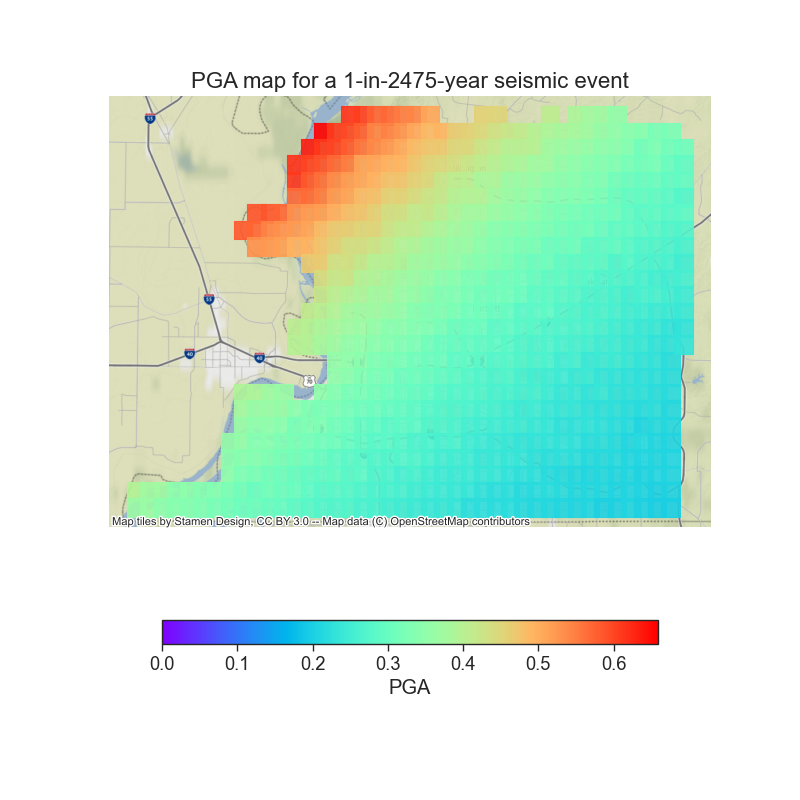

In [46]:
scenarios = os.listdir(MAIN_DIR/f'infrarisk/data/networks/shelby/hazards/earthquake/gmfs/2475')
gmf = pd.read_csv(MAIN_DIR/f'infrarisk/data/networks/shelby/hazards/earthquake/gmfs/2475/{scenarios[3]}')
gmf_gpd = gpd.GeoDataFrame(gmf, geometry=gpd.points_from_xy(gmf['lon_UTM'], gmf['lat_UTM'])).set_crs('epsg:3857')
earthquake_disruption.plot_imt(gmf_gpd, imt_column = 'PGA')

[0.10563664628326641,
 0.8601989550012651,
 0.007529487820369339,
 7.345832286433137e-08]

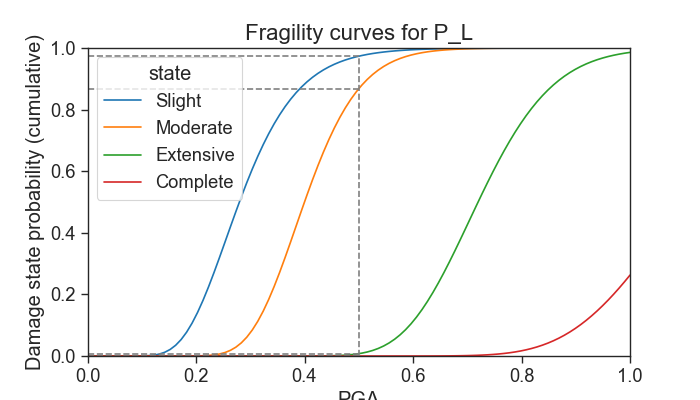

In [23]:
earthquake_disruption.ascertain_damage_probabilities(component = 'P_L65', imt_type = 'PGA', imt_value = 0.5)

[0.40668335950712775, 0.3296391387783958]

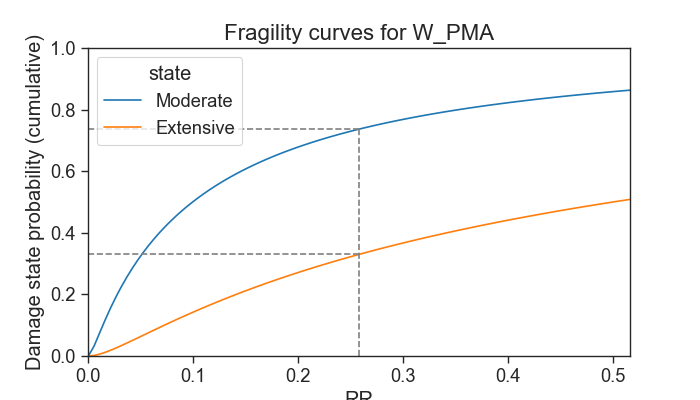

In [47]:
earthquake_disruption.ascertain_pipe_damage_probabilities(wn = shelby_network.wn, pipe = 'W_PMA45', gmf_gpd=gmf_gpd)

In [48]:
G = shelby_network.integrated_graph
earthquake_disruption.set_gmfs(G,gmf_gpd)

In [49]:
earthquake_disruption.set_affected_components(shelby_network, gmf_gpd, 7200, plot_components=True)
fail_probs_df = earthquake_disruption.get_affected_components()

In [11]:
earthquake_disruption.fail_probs_df.head()

,component,disruption_time,state_probs,disruption_state,recovery_time,infra,damage_perc
0,W_T65,7200,"[0.7226941752997049, 0.16457845045474845, 0.01...",Moderate,0,Water,25
1,W_T60,7200,"[0.7305833845514418, 0.09132296676904728, 0.00...",Slight,20.0,Water,0
2,W_T61,7200,"[0.7156608707263186, 0.07109546652746317, 0.00...",Slight,29.0,Water,0
3,W_T62,7200,"[0.5798358238594444, 0.02240096389085527, 0.00...",Slight,42.0,Water,0
4,W_T63,7200,"[0.6279033695988883, 0.031779375304722246, 0.0...",Slight,36.0,Water,0
...,...,...,...,...,...,...,...
437,T_L472,7200,"[0.3788586599581186, 0.2909980966041778, 0.040...",Slight,22.0,Transpo,0
438,T_L478,7200,"[0.3373972281101172, 0.4070281973408036, 0.096...",None,0,Transpo,0
439,T_L279,7200,"[0.37157965504349666, 0.3333184288545663, 0.05...",Slight,22.0,Transpo,0
440,T_L476,7200,"[0.13007594269036693, 0.4585721748389614, 0.38...",Slight,22.0,Transpo,0


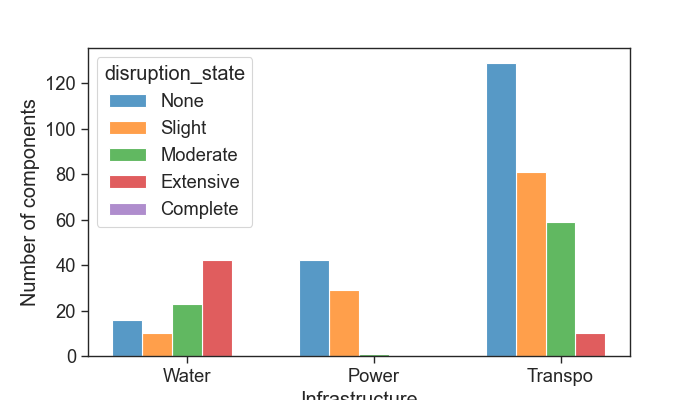

In [ ]:
earthquake_disruption.plot_failure_distributions()

### Write the disruption file to local directory

In [15]:
scenario_location = MAIN_DIR/network_dir/"scenarios/earthquake3"
earthquake_disruption.generate_disruption_file(location = scenario_location)

..\..\infrarisk\data\networks\shelby\scenarios\earthquake3
Successfully saved the disruption file (with 135 disruptions) to ..\..\infrarisk\data\networks\shelby\scenarios\earthquake3/


WindowsPath('../../infrarisk/data/networks/shelby/scenarios/earthquake3')